# Assignment 2

# Part 2: Classic recognition 

In [1]:
%load_ext autoreload
%autoreload 2

import os, pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils import get_CIFAR10_data, train, evaluate

In [2]:
meta = pickle.load(open('data/cifar-10-batches-py/batches.meta', 'rb'), encoding='bytes')
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(cifar10_dir='data/cifar-10-batches-py',
                                                                  num_training=4500, 
                                                                  num_validation=500, 
                                                                  num_test=1000)

Train data shape:  (4500, 32, 32, 3)
Train labels shape:  (4500,)
Validation data shape:  (500, 32, 32, 3)
Validation labels shape:  (500,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


## Question 2. Color features (5 points)

Train data shape:  (4500, 32, 32, 3)
Train labels shape:  (4500,)
Validation data shape:  (500, 32, 32, 3)
Validation labels shape:  (500,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)
reg 9.000000e-02 train accuracy: 0.120889 val accuracy: 0.144000

best validation accuracy achieved during training: 0.144000

final test set accuracy: 0.119000


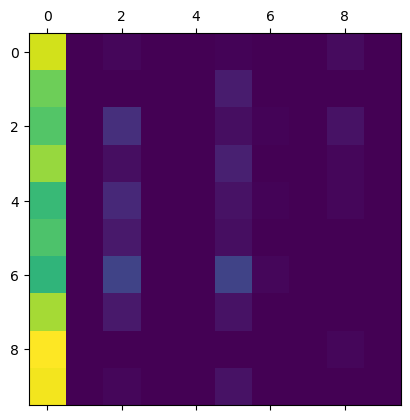

In [3]:
# ALL OPERATIONS
from assn2 import load_average_color_with_bias
from sklearn.metrics import confusion_matrix

regularization_strengths = [0.09]

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(cifar10_dir='data/cifar-10-batches-py',
                                                                  num_training=4500, 
                                                                  num_validation=500, 
                                                                  num_test=1000)
X_train = load_average_color_with_bias(X_train)
X_val = load_average_color_with_bias(X_val)
X_test = load_average_color_with_bias(X_test)
best_color = train(X_train, y_train, X_val, y_val, X_test, y_test, regularization_strengths)
C = confusion_matrix(y_test, best_color.predict(X_test))
plt.matshow(C)

## Question 3. Bag of SIFT features (15 points)

Train data shape:  (4500, 32, 32, 3)
Train labels shape:  (4500,)
Validation data shape:  (500, 32, 32, 3)
Validation labels shape:  (500,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)
reg 1.200000e+03 train accuracy: 0.235111 val accuracy: 0.246000

best validation accuracy achieved during training: 0.246000
final test set accuracy: 0.234000


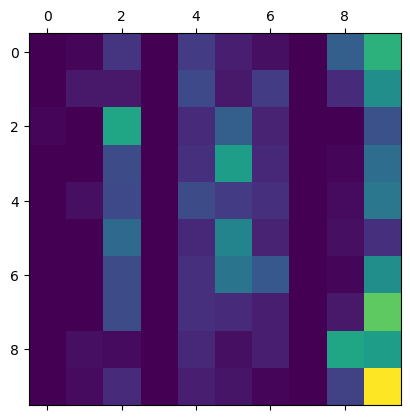

In [5]:
from features import extract_sift_for_dataset
from assn2 import load_flatten
from assn2 import load_histogram_with_bias
from kmeans import kmeans
from sklearn.metrics import confusion_matrix

step_size = 4
K = 16
niter = 4
regularization_strengths = [1.2e3]

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(cifar10_dir='data/cifar-10-batches-py',
                                                                  num_training=4500, 
                                                                  num_validation=500, 
                                                                  num_test=1000)
X_train_features = extract_sift_for_dataset(X_train, step_size=step_size)
X_val_features = extract_sift_for_dataset(X_val, step_size=step_size)
X_test_features = extract_sift_for_dataset(X_test, step_size=step_size)
X_train_features_flattened = load_flatten(X_train_features)
labels_train, centroids = kmeans(X_train_features_flattened, K, niter)
train_hist = load_histogram_with_bias(X_train_features, centroids)
val_hist = load_histogram_with_bias(X_val_features, centroids)
test_hist = load_histogram_with_bias(X_test_features, centroids)
best_color = train(train_hist, y_train, val_hist, y_val, test_hist, y_test, regularization_strengths, skip_test=True)
evaluate(best_color, test_hist, y_test)
C = confusion_matrix(y_test, best_color.predict(test_hist))
plt.matshow(C)

## Question 4. SPM representation (15 points)

In [5]:
from features import spatial_pyramid_matching_with_bias
from sklearn.metrics import confusion_matrix

L = 2
K = 16
niter = 4
regularization_strengths = [1e3]

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(cifar10_dir='data/cifar-10-batches-py',
                                                                  num_training=4500, 
                                                                  num_validation=500, 
                                                                  num_test=1000)
X_train_features = extract_sift_for_dataset(X_train, step_size=1)
X_train_features_flattened = load_flatten(X_train_features)
X_val_features = extract_sift_for_dataset(X_val, step_size=1)
X_test_features = extract_sift_for_dataset(X_test, step_size=1)
_, centroids = kmeans(X_train_features_flattened, K, niter)
X_train_spm = [spatial_pyramid_matching_with_bias(L, 
                                        X_train_features[i].reshape((32, 32, 128)), 
                                        centroids) 
            for i in range(len(X_train))]
X_val_spm = [spatial_pyramid_matching_with_bias(L,
                                      X_val_features[i].reshape((32, 32, 128)), 
                                      centroids) 
            for i in range(len(X_val))]
X_test_spm = [spatial_pyramid_matching_with_bias(L,
                                       X_test_features[i].reshape((32, 32, 128)),
                                       centroids)  
              for i in range(len(X_test))]
X_train_spm = np.stack(X_train_spm, 0)
X_val_spm = np.stack(X_val_spm, 0)
X_test_spm = np.stack(X_test_spm, 0)
best_color = train(X_train_spm, y_train, X_val_spm, y_val, X_test_spm, y_test, regularization_strengths, skip_test=True)
evaluate(best_color, X_test_spm, y_test)
C = confusion_matrix(y_test, best_color.predict(X_test_spm))
plt.matshow(C)

Train data shape:  (4500, 32, 32, 3)
Train labels shape:  (4500,)
Validation data shape:  (500, 32, 32, 3)
Validation labels shape:  (500,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)
reg 1.000000e+03 train accuracy: 0.286444 val accuracy: 0.272000

best validation accuracy achieved during training: 0.272000
final test set accuracy: 0.271000


## Question 5. Histogram of Oriented Gradients (10 points) 

In [9]:
from assn2 import load_hog_representation_with_bias
from sklearn.metrics import confusion_matrix

cell_size = 2
block_size = 4
regularization_strengths = [1e4]

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(cifar10_dir='data/cifar-10-batches-py',
                                                                  num_training=4500, 
                                                                  num_validation=500, 
                                                                  num_test=1000)
X_train_hog =  load_hog_representation_with_bias(X_train, cell_size, block_size)
X_val_hog = load_hog_representation_with_bias(X_val, cell_size, block_size)
X_test_hog = load_hog_representation_with_bias(X_test, cell_size, block_size)
best_color = train(X_train_hog, y_train, X_val_hog, y_val, X_test_hog, y_test, regularization_strengths)
C = confusion_matrix(y_test, best_color.predict(X_test_hog))
plt.matshow(C)

Train data shape:  (4500, 32, 32, 3)
Train labels shape:  (4500,)
Validation data shape:  (500, 32, 32, 3)
Validation labels shape:  (500,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)
reg 1.000000e+04 train accuracy: 0.152889 val accuracy: 0.126000

best validation accuracy achieved during training: 0.126000

final test set accuracy: 0.123000


## Question 6. Pixels (5 points)

In [7]:
from assn2 import load_vector_image_with_bias
from sklearn.metrics import confusion_matrix

regularization_strengths = [1.3e3]

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(cifar10_dir='data/cifar-10-batches-py',
                                                                  num_training=4500, 
                                                                  num_validation=500, 
                                                                  num_test=1000)
X_train, X_val, X_test = load_vector_image_with_bias(X_train, X_val, X_test)
best_color = train(X_train, y_train, X_val, y_val, X_test, y_test, regularization_strengths)
C = confusion_matrix(y_test, best_color.predict(X_test))
plt.matshow(C)

Train data shape:  (4500, 32, 32, 3)
Train labels shape:  (4500,)
Validation data shape:  (500, 32, 32, 3)
Validation labels shape:  (500,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)
reg 1.300000e+03 train accuracy: 0.188889 val accuracy: 0.202000

best validation accuracy achieved during training: 0.202000

final test set accuracy: 0.171000
